In [1]:
from pathlib import Path
import shutil

import pandas as pd
import numpy as np
import pickle
import seaborn as sns
from bs4 import BeautifulSoup
import locale
#from html.parser import HTMLParser
# import website_func.py to use its functions
from website_func import *
from scrap import *
import os #To read the file
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get

#Machine learning part
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.metrics import f1_score
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.neural_network import MLPClassifier

#reload every module each time
%load_ext autoreload
%autoreload 2

# Some quick analysis of the data
We received a data set of .html file containing the website content of recipes.
We wanted to sort them by website, in order to, more easily, find a pattern among them. This will enable us to do the "scraping" of the pages. First we thought about moving the files in a folder corresponding to their website, but it would be a waste of time and a big computational effort. Thus, we came up with a (probably) faster solution : we could simply write the name of the file within its corresponding website folder. By inspecting the files, we saw that the first line was always containing a comment with the name of the file and the complete website. Using readlines and split, we could easily retrieve the name of the website.

We launched this process, but an alarm appeared describing a Trojan virus in the file "1c2cb6f0df04cf5a9d0baa116c6aa7bb.html". 
We had then to quarantine or maybe remove the file, as we have quite enough data.
By doing so, we remarked the file "msg.log" that could help us into fastering the processus as its content is formed of the name of the file together with its website.

In [10]:
with open("recipePages/msg.log", 'r') as f:
    first_lines = f.readlines()[45:49]
    print(*first_lines, sep="--")

59b9d3c43ee8df52fcd04128475059f5.html	http://allrecipes.com/Recipe/bacon-and-potato-soup/detail.aspx	2012-09-09 10:55:41 URL:http://allrecipes.com/Recipe/bacon-and-potato-soup/detail.aspx [225697/225697] -> "59b9d3c43ee8df52fcd04128475059f5.tmp" [1]
--129b4dad66e6d0d59bbc6f3200f9e927.html	http://familyoven.com/recipes/search?terms=Dairy%20Free%20Alfredo%20Sauce	2012-09-09 10:55:42 URL:http://familyoven.com/recipes/search?terms=Dairy%20Free%20Alfredo%20Sauce [77640] -> "129b4dad66e6d0d59bbc6f3200f9e927.tmp" [1]
--bafcd30bc137238af0cd9954f7d0701e.html	http://www.yummly.com/recipes/chicken-brunswick-stew-lima-beans	Syntax error in Set-Cookie: fbsr_54208124338=""; Expires=Thu, 01-Jan-1970 00:00:10 GMT; Path=/, JSESSIONID=27D73083292D7FE540727DC4AD6C50D2; Path=/; HttpOnly, yv="lJSpLE5cHmHHgrNrJgtM/w=="; Version=1; Max-Age=31536000; Expires=Mon, 09-Sep-2013 17:55:42 GMT; Path=/ at position 120.
--2012-09-09 10:55:43 URL:http://www.yummly.com/recipes/chicken-brunswick-stew-lima-beans [286650]

We observed that occasionally a line containing other info that are not necessary can appear (in the example above, this is the case in the last line). Those lines are ignored during the sorting process.
Also we noticed there are no file extensions other than .html and .log (see below). Thus, we know exacty what the contents of the folder recipePages are.

In [11]:
# We can find in the folder that, excepted the html files, there is only the log
# Get all filenames (i.e. path) that are in recipePages folder 
pathlist = Path("recipePages/").glob('**/*')
i = 0
for path in pathlist:
     # because path is object not string
    path_in_str = str(path)
    if not path_in_str.endswith(".html"):
        print(path_in_str)

recipePages\msg.log


##### Sorting part of the content of the folder "recipePages" :

In [12]:
# If override True -> delete SortedFiles and re-execute the function (long)
sort_website_from_log(override=False)

Finished sorting the files


After the sorting comes the scraping part. In order to have the maximum number of data and to save some time, we'll first scrap the websites containing the higher number of files.

In [13]:
website_count=pd.Series()

for (root,dirs,files) in os.walk('SortedFiles', topdown="True"):   
        for website in dirs:
            if website == ".ipynb_checkpoints":
                continue
            filename = "SortedFiles/" + website +"/filesName.txt"
            
            f = open(filename, "r")
            number_of_link = len(f.readlines())
            line_to_add=pd.Series(number_of_link,index=[website])
            website_count = website_count.append(line_to_add)

In [14]:
#print(website_count)
print("Number of website with more than 1000 files:", len(website_count[website_count.values >1000]))
print("Number of website with less than 1000 files:", len(website_count[website_count.values <1000]))

Number of website with more than 1000 files: 19
Number of website with less than 1000 files: 85


As we can observe, 19 websites have a really high number of files, higher than a thousand. The number of files contained in the 3 first website represents 53% of the total number of files.Those are the ones that we'll focus our attention on.

In [15]:
website_count.sort_values(ascending=False,inplace=True)
website_count_used=website_count[website_count.values>1000]
print(website_count_used)
total_number_files = website_count_used.values.sum()
chosen_number_files = website_count_used[0:3].values.sum()

print("Number of files in the 3 first domains : ", chosen_number_files)
print("Percentage of chosen files among the total: ", chosen_number_files/total_number_files)

allrecipes.com             28355
food.com                   14661
foodnetwork.com            11997
yummly.com                  6590
cooks.com                   5547
epicurious.com              5060
tasteofhome.com             4820
myrecipes.com               3805
recipes.sparkpeople.com     3671
cdkitchen.com               2584
bettycrocker.com            2325
cookeatshare.com            2044
southernfood.about.com      2012
grouprecipes.com            1916
recipe.com                  1460
kraftrecipes.com            1420
eatingwell.com              1400
ifood.tv                    1295
delish.com                  1050
dtype: int64
Number of files in the 3 first domains :  55013
Percentage of chosen files among the total:  0.539279692585186


In [16]:
website_list_used=website_count_used.index.tolist()

There is a lot of words in the ingredients which aren't specific to the ingredient itself, but which are just linked to the quantity of the ingredients, or something uninteresting for us. It is difficult to extract the quantity of the ingredients, as there is a lot of different units for expressing them. Hence, we decided first to juste remove all those terms for the moment, and focus our attention only on the ingredients (not on the quantity). 

In [2]:
#Words that have to be removed from the string in the website to keep only the ingredient:
list_ingredient_to_remove = ["that", "store","tsp","such", "shape","softened","warm","how","generous","equivalent","bottom","needed","salted","replace","low","i","believe","ever", "only", "fine", "envelopes", "your","own","inches","run","through","perfect", "into","big","oz", "substitute","am","using","will", "enhance","the","not","may","be","correct","desired","you","like","less","in water","delicious","big","save","time","use the cheap cooking wine","or","gram","used","be", "little","more","gallon","gal","pound","pounds","if","let","sit","kg","works","really","is",\
                             "approximate","ml", "sprinkle","over","amount","dl","use", "a", "preserved","g","gr","real","raw","lb", "lbs","metrics",\
                             "metric","of","teaspoon", "cup", "cups","teaspoons","ounce","ounces","pounds","pound","tablespoons","chopped","quarts","fresh",\
                            "light","plain","popped","medium","shredded","bunch","tablespoon","to","taste","pinch","freshly","ground",\
                            "canned","carcass","cubes","dried","frozen","all","purpose","grated","minced","degree","degrees","optional",\
                            "jar","quartered","marinated","strips","strip","asian","stalks","package","can","cans","box","container",\
                            "evaporated","bottle","cans","extract","squares","german","slices","crushed","uncooked","seasoning","small",\
                            "sweet","packed","sliced","heavy","condensed","finely","long","grain","sweetened","firmly","cooked","crusts","lean",\
                            "caps","mix","steaks","large","instant","crumbs","semisweet","distilled","packages","pint","miniature","preserves",\
                            "processed","chunky","prepared","seasoned","american","stock","top","sirloin","tip","peeled","spears","leaves",\
                            "belgian","bob","italian","bottles","boneless","roast","breast","meat","tenderloins","granules","chips","converted",\
                            "containers","coleslaw","florets","cube","cubed","diced","crumbled","head","thighs","halves","drumsticks","blend",\
                            "leaf","bow","tie","stuffing","dry","boiling","cover","coarse","kosher","extra","virgin","fat","free","fluid","hot",\
                            "chops","loin","shoulder","roasted","for","frying","diced","thawed","bone","hocks","shucked","leftover","corned",\
                            "weed","summer","wild","whole","very","ripe","unbaked","crust","unsalted","unsifted","unsweetened","drops","drop",\
                            "paste","thickly","swiss","skinless","flavored","quart","puff","kernels","kernel","cracked","as","tortillas","chunk",\
                            "dash","dark","hash","brown","hashbrown","hungarian","rinsed","thin","thinly","thick","stewed","cleaned","gelatin",\
                            "sifted","skim","slivered","sprigs","sage","roma","romano","reduced","sodium","refried","refrigerated",\
                            "portobello","nuggets","tater","pinto","pudding","pitted","pinches","relish","penne","deep","mild","melted",\
                            "maraschino","loaf","link","jumbo","inch","jars","jasmine","generous","gold","graham","granulated","fried","skins",\
                            "fire","firm","flaked","flank","family","size","eagle","curd","half","russet","round","vidalia","unbleached","toll",\
                            "morsels","toasted","square","soft","sharp","serrano","seedless","old","provolone","process","premium","pouch","betty",\
                            "piri","chunks","smoked","other","original","breaded","tender","tenders","flowerets","nonfat","no","calorie","tail",\
                            "greek","great","northern","southern","envelope","dill","cold","round","steak","brisket","baby","assorted"]

list_ingredient_to_remove = sorted(list_ingredient_to_remove)
#print(list_ingredient_to_remove)

We can also add a list of ingredient (here fruit) that contains the average serving portion for each fruit. We scraped the website https://www.calories.info to get those measures.

In [ ]:
import requests
import re
# quantity in grams
fruit_quantity = pd.DataFrame(columns=["Fruit", "Quantity", "Units"])

website_fruit = "https://www.calories.info/food/fruits"
r = requests.get(website_fruit)
soup = BeautifulSoup(r.text, 'html.parser')
rows =  soup.find('tbody').findAll('tr')
for r in rows:
    name = r.find("a").text
    weight_gram = float(r.find("td", class_="serving portion").text.split("(")[1].replace(")","").split()[0])
#     print(weight_gram)
#     print(name)
    fruit_quantity =fruit_quantity.append({'Fruit':name.lower(), 'Quantity' : weight_gram, 'Units': "g"}, ignore_index = True)

fruit_quantity.to_pickle('data_pickles/fruit_quantity.pkl')
fruit_quantity = fruit_quantity.set_index("Fruit").T.to_dict("list")
fruit_quantity

### Creation of the recipe data:
We have to be aware of certain things:
- we might get a website containing only a list of recipes
- we might find no rating -> we'll have to discard it
- we might not be able to open and read the file

For the pages containing lists of recipes, we tried to get informations about those recipes, but were unsucessful. As some links referenced in those were dead.

### Schema used for the scraping :

We will based our dataset on the 3 first websites as said before. The variables we are interested in are the following :
- The ranking, in order to have a value representing the success of the recipe.
- The number of reviews, in order to have an idea of the confidence interval for the ranking estimation.
- The time of preparation, which is a candidate which will be used to predict the ranking.
- The ingredients : The candidate which will be used to predict the ranking.

We haven't yet decided what to do exactly with the number of reviews, but as we want our ranking estimation to be significant enough, we could simply remove the recipes with a too small number of reviews.

## Pickle part of food.com

The scraping takes a lot of time, then, after each website scraped, we store the results in pickles files.

In [19]:
# Scrap all food.com files and put them in a pickle file
recipe_data_food = pd.DataFrame(columns = ['Website','Recipe','Prepare time', 'Ranking', 'Reviews', 'Ingredients'])  
list_unique_ingredients_food = []
unique_ingredients_data_food = pd.DataFrame(columns = ['Ingredient','Count'])
path_to_food_folder = Path('SortedFiles/food.com/filesName.txt')
print(path_to_food_folder)

with path_to_food_folder.open("r") as file:
    website = "food.com"
    for f in file.readlines():
        file_to_read =Path('recipePages') / f.strip()
        try:
            f = open(file_to_read,'r')
            f.close()
        except:
            #print("We can't read the page: ",file_to_read)
            continue
        recipe_data_food, list_unique_ingredients_food, unique_ingredients_data_food = scrap_food(website, file_to_read,list_ingredient_to_remove,list_unique_ingredients_food, recipe_data_food, website_list_used,unique_ingredients_data_food)
                                            
recipe_data_food


SortedFiles\food.com\filesName.txt
No name found : We don't care about this page:  recipePages\fe40cc6943ac62075037671548c11d29.html
No ingredients found : recipePages\4e986b9a96318c9a90180a4cf4fd3ba2.html
No name found : We don't care about this page:  recipePages\f1ae109ce618a934723c30a2280b6f6c.html
No name found : We don't care about this page:  recipePages\35ca1630d124857bdc826126296c684e.html
No ingredients found : recipePages\532e22db484f5da106d7260a634b5240.html
No name found : We don't care about this page:  recipePages\40c8ce6f93392b2ecfce69f66e8e0fff.html
No name found : We don't care about this page:  recipePages\7231114901f0a036b65eab526148e5e8.html
No name found : We don't care about this page:  recipePages\4c433c4eb3cc6af1d25630e21c447715.html
No name found : We don't care about this page:  recipePages\6a3b7c2cdb875d7c2a845f76a04f6313.html
Beautifulsoup can't read the page (food.com): recipePages\db8dbc0241a864cde936ef0ec9ba98d1.html
No name found : We don't care about t

KeyboardInterrupt: 

In [24]:
recipe_data_food

,Website,Recipe,Prepare time,Ranking,Reviews,Ingredients
0,food.com,Ecuadorean Quinoa and Vegetable Soup,75,4.86,31,"[quinoa, olive oil, onions, salt, potato, red ..."
1,food.com,Authentic Injera (aka Ethiopian Flat Bread),4330,3.13,17,"[teff, water, salt]"
2,food.com,Healthy Vegan Coleslaw,10,5.00,1,"[cabbage, vegan mayonnaise, apple cider vinega..."
3,food.com,Grilled Flatbread,35,4.67,14,"[active yeast, olive oil, flour, salt]"
4,food.com,Baked Margarita Pie,20,5.00,3,"[cracker, milk]"
...,...,...,...,...,...,...
168,food.com,No-Salt White Bread,185,4.50,2,"[warm water, olive oil, sugar, flour]"
169,food.com,Strawberry Shortcake Cupcakes,49,5.00,1,"[flour, baking powder, baking soda, salt, butt..."
170,food.com,Homemade Poultry Seasoning,5,4.93,31,"[rosemary, nutmeg, black pepper]"
171,food.com,Microwave Baked Custard,26,5.00,1,"[milk, egg, sugar, salt, vanilla]"


##### Save data with pickle:

In [21]:
recipe_data_food.to_pickle("data_pickles/recipe_data_food.pkl")
unique_ingredients_data_food.to_pickle("data_pickles/unique_ingredients_data_food.pkl")
with open('data_pickles/list_uni_ingr_food.pkl', 'wb') as f:
    pickle.dump(list_unique_ingredients_food, f)

##### Retrieve data with pickle:

In [3]:
recipe_data = pd.read_pickle("data_pickles/recipe_data_food.pkl")
unique_ingredients_data = pd.read_pickle("data_pickles/unique_ingredients_data_food.pkl")
with open('data_pickles/list_uni_ingr_food.pkl', 'rb') as f:
    list_unique_ingredients = pickle.load(f)

In [4]:
unique_ingredients_data

,Ingredient,Count
0,quinoa,39
1,olive oil,1931
2,onions,1
3,salt,5515
4,potato,106
...,...,...
1634,chicory lettuce,1
1635,parma ham,1
1636,tagliatelle noodles,2
1637,vegan cheese,1


In [ ]:
# Scrap all foodnetwork.com files and put them in a pickle file
path_to_foodnet_folder = Path('SortedFiles/foodnetwork.com/filesName.txt')
print(path_to_foodnet_folder)

with path_to_foodnet_folder.open("r") as file:
    website = "foodnetwork.com"
    for f in file.readlines():
        file_to_read =Path('recipePages') / f.strip()
        try:
            f = open(file_to_read,'r')
            f.close()
        except:
            #print("We can't read the page: ",file_to_read)
            continue
        recipe_data,list_unique_ingredients, unique_ingredients_data= scrap_foodnetwork(website, file_to_read,list_ingredient_to_remove,list_unique_ingredients, recipe_data, website_list_used,unique_ingredients_data)


In [239]:
recipe_data.to_pickle("data_pickles/recipe_data_foodnet.pkl")
unique_ingredients_data.to_pickle("data_pickles/unique_ingredients_data_foodnet.pkl")
with open('data_pickles/list_uni_ingr_foodnet.pkl', 'wb') as f:
    pickle.dump(list_unique_ingredients_food, f)

In [245]:
recipe_data = pd.read_pickle("data_pickles/recipe_data_foodnet.pkl")
unique_ingredients_data = pd.read_pickle("data_pickles/unique_ingredients_data_foodnet.pkl")
with open('data_pickles/list_uni_ingr_foodnet.pkl', 'rb') as f:
    list_unique_ingredients = pickle.load(f)

In [26]:
# Scrap allrecipes.com files and put them in a pickle file
path_to_allrec_folder = Path('SortedFiles/allrecipes.com/filesName.txt')
print(path_to_allrec_folder)

with path_to_allrec_folder.open("r") as file:
    website = "allrecipes.com"
    for f in file.readlines():
        file_to_read =Path('recipePages') / f.strip()
        try:
            f = open(file_to_read,'r')
            f.close()
        except:
            #print("We can't read the page: ",file_to_read)
            continue
        recipe_data, list_unique_ingredients, unique_ingredients_data = scrap_allrecipes(website, file_to_read,list_ingredient_to_remove,list_unique_ingredients, recipe_data, website_list_used,unique_ingredients_data)


SortedFiles\allrecipes.com\filesName.txt
We don't care about this page:  recipePages\c6a40a7de4b506a935093b67bccf4aac.html


KeyboardInterrupt: 

In [29]:
recipe_data.to_pickle("data_pickles/recipe_data_complete.pkl")
unique_ingredients_data.to_pickle("data_pickles/unique_ingredients_data_complete.pkl")
with open('data_pickles/list_uni_ingr_complete.pkl', 'wb') as f:
    pickle.dump(list_unique_ingredients_food, f)

In [6]:
recipe_data = pd.read_pickle("data_pickles/recipe_data_complete.pkl")
unique_ingredients_data = pd.read_pickle("data_pickles/unique_ingredients_data_complete.pkl")
with open('data_pickles/list_uni_ingr_complete.pkl', 'rb') as f:
    list_unique_ingredients = pickle.load(f)

In [7]:
recipe_data

,Website,Recipe,Prepare time,Ranking,Reviews,Ingredients
0,food.com,Ecuadorean Quinoa and Vegetable Soup,75,4.86,31,"[quinoa, olive oil, onions, salt, potato, red ..."
1,food.com,Authentic Injera (aka Ethiopian Flat Bread),4330,3.13,17,"[teff, water, salt]"
2,food.com,Healthy Vegan Coleslaw,10,5,1,"[cabbage, vegan mayonnaise, apple cider vinega..."
3,food.com,Grilled Flatbread,35,4.67,14,"[active yeast, olive oil, flour, salt]"
4,food.com,Baked Margarita Pie,20,5,3,"[cracker, milk]"
...,...,...,...,...,...,...
43944,allrecipes.com,Oven-Fried Chicken,NaN,4.1,19,"[buttermilk baking, pecan, paprika, salt, poul..."
43945,allrecipes.com,Pumpkin Spice Cake with Cinnamon Cream Cheese ...,50,4.5,83,"[pumpkin puree, cinnamon, clove, nutmeg, yello..."
43946,allrecipes.com,Mom's Pie Crust for a Double Crust Pie,15,5.0,1,"[flour, salt, vegetable shortening, water]"
43947,allrecipes.com,Sopapilla Cheesecake Pie,180,4.8,882,"[cream cheese, white sugar, mexican vanilla, c..."


In [ ]:
recipe_data.groupby(['Recipe','Website','Reviews','Ranking']).count().sort_values(by=['Ingredients'])

To Do: Reset index for unique_ingredients_data

We choose to take only the ingredients which have an higher value than 200.

### Preprocessing:
As a first step, we need to select the features on which we will train our model. This selection will help us to focus on the most important variables and hence to reduce the dimensionality. Furthermore, making a selection will simplify the model and avoid overfitting. We will test a couple of methods for feature extraction, but first of all, a good approach is to analyze the correlations between our variables.

Before, to do that, we have to work on 2 points :
- A) One of our task is to analyze the success of ingredients in recipes. To ensure a certain confidence in our statistics, the ingredient analyzed should appear in a lot of recipes. Then, we have to suppress all the rare ingredients (the ingredients which appear only a small number of times in our dataset).
- B) We want to have an idea of how important is each ingredient in recipes. Then we choose to give weights to each ingredient within each recipes. Ideally, we would set the weigth as $\frac{ingredient\_mass}{sum\_of\_ingredient\_mass}$.  As we didn't achieved to scrap correctly these $ingredient\_mass$ for the moment, we approximate these weights by $\frac{1}{(number\_ of\_ingredient\_in\_the\_recipe)}$

A) let's ignore the ingredients which appear less than minAppearingThresh

,Ingredient,Count
3,salt,23588
42,butter,13534
33,sugar,11660
22,flour,10896
73,egg,10637
...,...,...
352,plum tomatoes,205
276,pine nuts,205
1720,yellow cake,204
1648,good olive oil,202


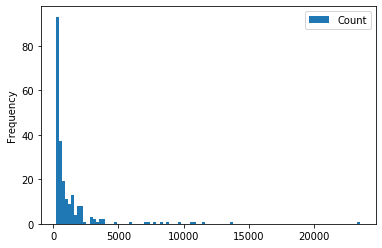

In [8]:
minAppearingThresh = 200
unique_ingredients_data.sort_values(by=["Count"], ascending=False,inplace=True)
unique_ingredients_data[unique_ingredients_data['Count'].values>minAppearingThresh].plot.hist(x="Ingredient", y="Count", bins=100)
unique_ingredients_data=unique_ingredients_data[unique_ingredients_data['Count'].values>minAppearingThresh]
unique_ingredients_data

In [9]:
unique_ingredients_data.shape

(226, 2)

In [7]:
AcceptedList_Ingredients = unique_ingredients_data['Ingredient'].tolist()
for f in range(len(recipe_data['Ingredients'])):
    newList = [s for s in recipe_data['Ingredients'].iloc[f] if s in AcceptedList_Ingredients]
    recipe_data['Ingredients'].iloc[f] =newList

B) Let's compute the weight of each ingredients within each recipe and put these values in a more representative dataframe for the following.

In [8]:
nbVariables = len(AcceptedList_Ingredients) + 1
nbDataPoints = recipe_data.shape[0]
#Ranking_ingredients_dataframe = pd.DataFrame(0, index=np.arange(0,nbDataPoints), columns =['Ranking','Prepare time'] + [a for a in AcceptedList_Ingredients])
#enlevé prepare time pr test car pas meme scale
Ranking_ingredients_dataframe = pd.DataFrame(0, index=np.arange(0,nbDataPoints), columns =['Ranking'] + [a for a in AcceptedList_Ingredients])


for f in range(len(recipe_data['Ranking'])):
    Ranking_ingredients_dataframe['Ranking'].iloc[f] = recipe_data['Ranking'].iloc[f]
    #Ranking_ingredients_dataframe['Prepare time'].iloc[f] = recipe_data['Prepare time'].iloc[f]
    number_of_ingredients = len(recipe_data['Ingredients'].iloc[f])
    weight = 0
    if number_of_ingredients != 0:
        weight = 1/number_of_ingredients
    for i in recipe_data['Ingredients'].iloc[f]:
        Ranking_ingredients_dataframe[i].iloc[f] = weight 

C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [9]:
Ranking_ingredients_dataframe

,Ranking,salt,butter,sugar,flour,egg,onion,black pepper,water,olive oil,...,marjoram,black peppercorn,caper,peanut oil,peaches,plum tomatoes,pine nuts,yellow cake,good olive oil,granny smith apple
0,4.86,0.083333,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.083333,0.083333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,3.13,0.500000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.500000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,5,0.200000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,4.67,0.250000,0.000000,0.000000,0.250000,0.000000,0.0,0.0,0.000000,0.250000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43944,4.1,0.142857,0.142857,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
43945,4.5,0.000000,0.076923,0.076923,0.000000,0.076923,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.0
43946,5.0,0.333333,0.000000,0.000000,0.333333,0.000000,0.0,0.0,0.333333,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
43947,4.8,0.000000,0.166667,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


Now that we have all our recipes in a dataframe where each ingredient as well as the rating are columns, we can compute the correlation matrix.

In [10]:
Ranking_ingredients_dataframe['Ranking'] = np.array([float(x) for x in Ranking_ingredients_dataframe['Ranking'].values])
corrMatrix = Ranking_ingredients_dataframe.corr()
corrMatrix

,Ranking,salt,butter,sugar,flour,egg,onion,black pepper,water,olive oil,...,marjoram,black peppercorn,caper,peanut oil,peaches,plum tomatoes,pine nuts,yellow cake,good olive oil,granny smith apple
Ranking,1.000000,0.023695,0.003896,-0.007909,-0.011604,-0.023415,-0.015005,0.057946,-0.022458,0.010691,...,-0.007544,-0.003395,0.003609,0.008325,0.002969,0.011308,0.011024,0.007685,0.031005,0.001621
salt,0.023695,1.000000,-0.010937,-0.090541,0.080325,-0.007613,-0.035382,0.189413,-0.034444,0.090792,...,-0.006475,0.008270,-0.002076,0.009873,-0.024128,-0.000814,0.007178,-0.038423,0.064429,-0.019970
butter,0.003896,-0.010937,1.000000,0.082100,0.130449,0.042817,-0.074311,-0.062451,-0.073319,-0.119340,...,-0.021923,-0.024206,-0.015795,-0.016244,0.001330,-0.019884,-0.018537,0.010605,-0.012379,0.006288
sugar,-0.007909,-0.090541,0.082100,1.000000,0.040963,0.017337,-0.125399,-0.130882,0.035948,-0.118832,...,-0.018087,-0.005252,-0.022980,-0.008791,0.003102,-0.014301,-0.022353,0.001281,-0.022770,0.018224
flour,-0.011604,0.080325,0.130449,0.040963,1.000000,0.200711,-0.112651,-0.093492,-0.032372,-0.113379,...,-0.016385,-0.025901,-0.016190,0.005919,0.009080,-0.021768,-0.024802,-0.019400,-0.022022,-0.003484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
plum tomatoes,0.011308,-0.000814,-0.019884,-0.014301,-0.021768,-0.022333,0.003103,0.013931,-0.012479,0.023562,...,-0.001430,-0.001104,0.008003,-0.000382,-0.002656,1.000000,-0.001963,-0.002510,0.022719,-0.002715
pine nuts,0.011024,0.007178,-0.018537,-0.022353,-0.024802,-0.023099,-0.014587,0.023728,-0.016863,0.054942,...,-0.003981,-0.003997,0.002730,-0.003222,-0.003309,-0.001963,1.000000,-0.003127,0.003149,-0.003383
yellow cake,0.007685,-0.038423,0.010605,0.001281,-0.019400,0.025562,-0.021833,-0.021250,-0.002419,-0.017709,...,-0.003115,-0.003127,-0.003109,-0.002521,0.013134,-0.002510,-0.003127,1.000000,-0.003146,0.008074
good olive oil,0.031005,0.064429,-0.012379,-0.022770,-0.022022,-0.022809,-0.023226,0.131663,-0.019612,-0.022778,...,-0.004006,-0.004022,0.022354,-0.003243,-0.003330,0.022719,0.003149,-0.003146,1.000000,0.002540


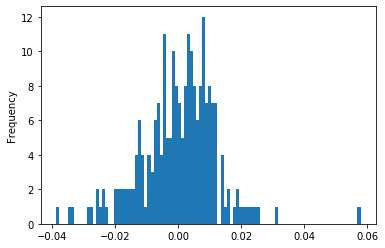

In [11]:
# illustration of the correlation between each variable and the ranking
variableToRankingCorr = corrMatrix.iloc[0].drop('Ranking')
variableToRankingCorr.plot.hist(bins=100)


We can see on this histogram that most of the variables are not correlated with the ranking. Then, we can select our features by keeping only the variables which have a reasonnable correlation with the ranking. This method of selection gives representative results iff the variables are linear enough with the ranking. We will test more robust methods for feature selection later, as PCA, ICA, random forest, ...

In [12]:
# We will choose a threshold such as we keep only the correlations bigger than it.
threshold = 0.01
variableToKeep = variableToRankingCorr[np.abs(variableToRankingCorr) > threshold]
variableToKeep = variableToKeep.index.values
features = variableToKeep
features

array(['salt', 'flour', 'egg', 'onion', 'black pepper', 'water',
       'olive oil', 'white sugar', 'milk', 'vanilla', 'vegetable oil',
       'baking powder', 'cloves garlic', 'parsley', 'baking soda',
       'lemon juice', 'garlic', 'carrot', 'garlic clove', 'chicken broth',
       'nutmeg', 'mayonnaise', 'thyme', 'cumin', 'cayenne pepper',
       'worcestershire sauce', 'ginger', 'bay', 'clove garlic', 'bacon',
       'corn', 'white wine', 'white vinegar', 'shortening', 'rosemary',
       'lime juice', 'cocoa powder', 'yellow onion', 'rice',
       'active yeast', 'shallot', 'banana', 'red wine vinegar',
       'white rice', 'wheat flour', 'yogurt', 'parmesan', 'cracker',
       'cucumber', 'jalapeno pepper', 'rolled oat', 'sauce', 'salsa',
       'curry powder', 'whipped topping', 'feta cheese',
       'vegetable broth', 'coconut milk', 'potato', 'green pepper',
       'chicken bouillon', 'applesauce', 'peas', 'green chilies',
       'cake flour', 'cream tartar', 'cottage cheese', 

Here we have a very easy way to select our features. We can now select a training set and a testing test, after what we can implement and test a regression model of order 1.

##### Drop every ingredient that don't have enough correlation with the final ranking

In [13]:
columns_to_keep = features.tolist()
columns_to_keep.extend(['Ranking','Prepare time'])
drop_columns = list(set(Ranking_ingredients_dataframe.columns) - set(columns_to_keep))  #List of columns to drop
Ranking_ingredients_correlation = Ranking_ingredients_dataframe.drop(drop_columns, axis=1)
Ranking_ingredients_correlation

'''
#Remove NaNs in 'Prepare time':
median_time = Ranking_ingredients_correlation['Prepare time'].quantile(0.5)
for i in range(len(Ranking_ingredients_correlation.index)) :
    if np.isnan(Ranking_ingredients_correlation['Prepare time'][i]) == True: #player_features.SprintSpeed[i] = median_speed
        Ranking_ingredients_correlation['Prepare time'].iloc[i] = median_time
        #print('Sprint speed in row', i, '=', Ranking_ingredients_correlation['Prepare time'].iloc[i])
'''

"\n#Remove NaNs in 'Prepare time':\nmedian_time = Ranking_ingredients_correlation['Prepare time'].quantile(0.5)\nfor i in range(len(Ranking_ingredients_correlation.index)) :\n    if np.isnan(Ranking_ingredients_correlation['Prepare time'][i]) == True: #player_features.SprintSpeed[i] = median_speed\n        Ranking_ingredients_correlation['Prepare time'].iloc[i] = median_time\n        #print('Sprint speed in row', i, '=', Ranking_ingredients_correlation['Prepare time'].iloc[i])\n"

In [14]:
train_x, test_x,train_y, test_y = train_test_split(Ranking_ingredients_correlation\
                        .drop(['Ranking'], axis = 1), Ranking_ingredients_correlation['Ranking'], test_size=0.30)

In [15]:
'''
error_train = np.zeros(101)
alpha_range = np.linspace(0, 10, num=101)
for reg_param in range(101):
    ridge = Ridge(alpha=alpha_range[reg_param])
    scores = cross_validate(ridge,  train_x, train_y, cv=5,scoring=("neg_mean_squared_error"))
    error_train[reg_param] = np.abs(np.mean(scores["test_score"]))
'''
error_train = np.zeros(101)
alpha_range = np.arange(101)
for reg_param in range(101):
    ridge = Ridge(alpha=reg_param)
    scores = cross_validate(ridge,  train_x, train_y, cv=5,scoring=("neg_mean_squared_error"))
    error_train[reg_param] = np.abs(np.mean(scores["test_score"]))

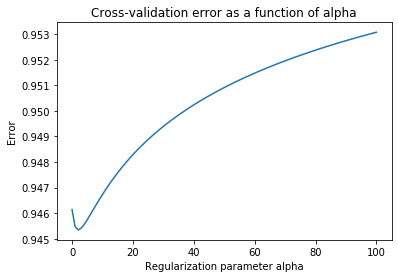

In [16]:
plt.title('Cross-validation error as a function of alpha')
plt.xlabel('Regularization parameter alpha')
plt.ylabel('Error')
plt.plot(alpha_range, error_train)

In [17]:
best_alpha = np.argmin(error_train)
print('The alpha giving the lowest error is:', alpha_range[best_alpha])

The alpha giving the lowest error is: 2


We train the model with the best alpha obtained, and we test it over our test set:

In [18]:
ridge_opt = Ridge(alpha = alpha_range[best_alpha])
ridge_opt.fit(train_x, train_y)
print('Mean squared error =', mean_squared_error(test_y, ridge_opt.predict(test_x)))

Mean squared error = 0.9399546652974848


In [19]:
nbVariables = len(AcceptedList_Ingredients) + 1
nbDataPoints = recipe_data.shape[0]
Ranking_ingredients_dataframe = pd.DataFrame(0, index=np.arange(0,nbDataPoints), columns =['Ranking'] + [a for a in AcceptedList_Ingredients])

for f in range(len(recipe_data['Ranking'])):
    Ranking_ingredients_dataframe['Ranking'].iloc[f] = recipe_data['Ranking'].iloc[f]
    number_of_ingredients = len(recipe_data['Ingredients'].iloc[f])
    weight = 0
    if number_of_ingredients != 0:
        weight = 1
    for i in recipe_data['Ingredients'].iloc[f]:
        Ranking_ingredients_dataframe[i].iloc[f] = weight 

C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [20]:
columns_to_keep = features.tolist()
columns_to_keep.append('Ranking')
drop_columns = list(set(Ranking_ingredients_dataframe.columns) - set(columns_to_keep))  #List of columns to drop
Ranking_ingredients_correlation = Ranking_ingredients_dataframe.drop(drop_columns, axis=1)
Ranking_ingredients_correlation

,Ranking,salt,flour,egg,onion,black pepper,water,olive oil,white sugar,milk,...,cherries,elbow macaroni,pickle,cayenne,salmon fillet,cheddar,tofu,plum tomatoes,pine nuts,good olive oil
0,4.86,1,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.13,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.67,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43944,4.1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
43945,4.5,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43946,5.0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43947,4.8,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
error_train = np.zeros(101)
alpha_range = np.arange(101)
for reg_param in range(101):
    ridge = Ridge(alpha=reg_param)
    scores = cross_validate(ridge,  train_x, train_y, cv=5,scoring=("neg_mean_squared_error"))
    error_train[reg_param] = np.abs(np.mean(scores["test_score"]))

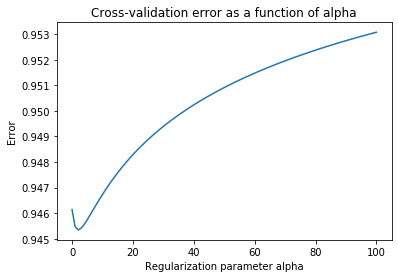

In [22]:
plt.title('Cross-validation error as a function of alpha')
plt.xlabel('Regularization parameter alpha')
plt.ylabel('Error')
plt.plot(alpha_range, error_train)

In [26]:
nbVariables = len(AcceptedList_Ingredients) + 1
nbDataPoints = recipe_data.shape[0]
#Ranking_ingredients_dataframe = pd.DataFrame(0, index=np.arange(0,nbDataPoints), columns =['Ranking','Prepare time'] + [a for a in AcceptedList_Ingredients])
#enlevé prepare time pr test car pas meme scale
Ranking_ingredients_dataframe2 = pd.DataFrame(0, index=np.arange(0,nbDataPoints), columns =['Ranking'] + [a for a in AcceptedList_Ingredients])


for f in range(len(recipe_data['Ranking'])):
    Ranking_ingredients_dataframe2['Ranking'].iloc[f] = recipe_data['Ranking'].iloc[f]
    #Ranking_ingredients_dataframe['Prepare time'].iloc[f] = recipe_data['Prepare time'].iloc[f]
    number_of_ingredients = len(recipe_data['Ingredients'].iloc[f])
    weight = 0
    if number_of_ingredients != 0:
        weight = 1
    for i in recipe_data['Ingredients'].iloc[f]:
        Ranking_ingredients_dataframe2[i].iloc[f] = weight 

In [27]:
Ranking_ingredients_dataframe2.to_pickle("data_pickles/Ranking_ingredients_dataframe2.pkl")

In [2]:
Ranking_ingredients_dataframe2 = pd.read_pickle("data_pickles/Ranking_ingredients_dataframe2.pkl")

In [5]:
Ranking_ingredients_dataframe2.shape

(43949, 227)

In [10]:
Ranking_threshold_list = np.linspace(3.0, 4.9, num=20)
f1_score_list = np.zeros(len(Ranking_threshold_list))
Ranking_ingredients_dataframe_boolean = Ranking_ingredients_dataframe2.copy()
for f in range(len(Ranking_threshold_list)):
    
    #Determine if the recipie is good or not depending on the threshold
    for i in range(len(Ranking_ingredients_dataframe2['Ranking'])):
        if float(Ranking_ingredients_dataframe2['Ranking'].iloc[i]) > float(Ranking_threshold_list[f]):
            Ranking_ingredients_dataframe_boolean['Ranking'].iloc[i] = 1.0
        else:
            Ranking_ingredients_dataframe_boolean['Ranking'].iloc[i] = 0.0
            
    #Split the dataset in train and test
    x_train, x_test,y_train, y_test = train_test_split(Ranking_ingredients_dataframe_boolean\
                    .drop(['Ranking'], axis = 1), Ranking_ingredients_dataframe_boolean['Ranking'], test_size=0.30)
    #create the model 
    logistic = LogisticRegression(solver='lbfgs')
    logistic.fit(x_train, y_train)
    
    #predict the output
    y_pred = logistic.predict(x_test)
    
    #test the model on the test set
    f1_score_list[f] = f1_score(y_test, y_pred, average='macro')

ValueError: Unknown label type: 'unknown'

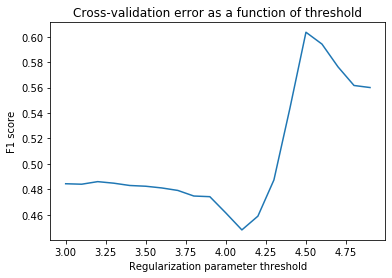

In [7]:
plt.title('Cross-validation error as a function of threshold')
plt.xlabel('Regularization parameter threshold')
plt.ylabel('F1 score')
plt.plot(Ranking_threshold_list,f1_score_list)

In [8]:
index_argmax=np.argmax(f1_score_list)

for i in range(len(Ranking_ingredients_dataframe2['Ranking'])):
    if float(Ranking_ingredients_dataframe2['Ranking'].iloc[i]) > float(Ranking_threshold_list[index_argmax]):
        Ranking_ingredients_dataframe_boolean['Ranking'].iloc[i] = 1.0
    else:
        Ranking_ingredients_dataframe_boolean['Ranking'].iloc[i] = 0.0
            
#Split the dataset in train and test
x_train, x_test,y_train, y_test = train_test_split(Ranking_ingredients_dataframe_boolean\
                .drop(['Ranking'], axis = 1), Ranking_ingredients_dataframe_boolean['Ranking'], test_size=0.30)
#create the model 
logistic = LogisticRegression(solver='lbfgs')
logistic.fit(x_train, y_train)

#predict the output
y_pred = logistic.predict(x_test)

#test the model 
f1_score_value = f1_score(y_test.values, y_pred, average='macro')
print('The f1 score is:',f1_score_value,' using a Raning threshold of:',Ranking_threshold_list[index_argmax])
print('The confusion matrix is centred and express as:',confusion_matrix(y_test, y_pred))

C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


The f1 score is: 0.6007584404614766  using a Raning threshold of: 4.5
The confusion matrix is centred and express as: [[4090 2607]
 [2655 3833]]


### Train with more than one output

In [ ]:
Ranking_threshold_below_list = np.linspace(3.0, 4.9, num=20)

f1_score_list = np.zeros(len(Ranking_threshold_list))
Ranking_ingredients_dataframe_boolean = Ranking_ingredients_dataframe2.copy()
for f in range(len(Ranking_threshold_list)):
    
    #Determine if the recipie is good or not depending on the threshold
    for i in range(len(Ranking_ingredients_dataframe2['Ranking'])):
        if float(Ranking_ingredients_dataframe2['Ranking'].iloc[i]) > float(Ranking_threshold_list[f]):
            Ranking_ingredients_dataframe_boolean['Ranking'].iloc[i] = 1.0
        else:
            Ranking_ingredients_dataframe_boolean['Ranking'].iloc[i] = 0.0
            
    #Split the dataset in train and test
    x_train, x_test,y_train, y_test = train_test_split(Ranking_ingredients_dataframe_boolean\
                    .drop(['Ranking'], axis = 1), Ranking_ingredients_dataframe_boolean['Ranking'], test_size=0.30)
    #create the model 
    logistic = MultiOutputClassifier(LogisticRegression(solver='lbfgs'))
    logistic.fit(x_train, y_train)
    
    #predict the output
    y_pred = logistic.predict(x_test)
    
    #test the model on the test set
    f1_score_list[f] = f1_score(y_test, y_pred, average='macro')

In [3]:
Ranking_ingredients_dataframe2['Ranking'] = Ranking_ingredients_dataframe2['Ranking'].astype(float)

In [18]:
def Ranking_function(bottom_value,top_value,Ranking_value):
    if Ranking_value > bottom_value:
        if Ranking_value > top_value:
            Ranking = 2.0
        else:
            Ranking = 1.0
    else:
        Ranking = 0.0
    return Ranking

def Ranking_function_unique(Ranking_threshold,Ranking_value):
    if Ranking_value > Ranking_threshold:
        Ranking = 1.0
    else:
        Ranking = 0.0
    return Ranking

def float2binary(value):
    if value>0.5:
        return 1.0
    else:
        return 0.0

In [16]:
Ranking_threshold_list= np.linspace(3.0, 4.9, num=20)
f1_score_list = np.zeros((len(Ranking_threshold_list),len(Ranking_threshold_list)))
Ranking_ingredients_dataframe_boolean = Ranking_ingredients_dataframe2.copy()

for idx_Ranking_bottom in range(len(Ranking_threshold_list)):
    print('idx_Ranking_bottom is:',idx_Ranking_bottom )
    for idx_Ranking_top in range(idx_Ranking_bottom+1,len(Ranking_threshold_list)):
        Ranking_bottom = Ranking_threshold_list[idx_Ranking_bottom]
        Ranking_top = Ranking_threshold_list[idx_Ranking_top]
        Ranking_ingredients_dataframe_boolean['Ranking'] = Ranking_ingredients_dataframe2['Ranking'].apply(lambda x:Ranking_function(Ranking_bottom,Ranking_top,x))

            
        #Split the dataset in train and test
        x_train, x_test,y_train, y_test = train_test_split(Ranking_ingredients_dataframe_boolean\
                        .drop(['Ranking'], axis = 1), Ranking_ingredients_dataframe_boolean['Ranking'], test_size=0.30)
        #create the model 
        logistic = LogisticRegression(solver='lbfgs',multi_class='ovr',max_iter=500)
        logistic.fit(x_train, y_train)

        #predict the output
        y_pred = logistic.predict(x_test)

        #test the model on the test set
        f1_score_list[idx_Ranking_bottom,idx_Ranking_top] = f1_score(y_test, y_pred, average='macro')
        
print("F1 score" , f1_score_list)

idx_Ranking_bottom is: 0


C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jacop\Anaconda3

idx_Ranking_bottom is: 1


C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jacop\Anaconda3

idx_Ranking_bottom is: 2


C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jacop\Anaconda3

idx_Ranking_bottom is: 3


C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jacop\Anaconda3

idx_Ranking_bottom is: 4


C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jacop\Anaconda3

idx_Ranking_bottom is: 5


C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


idx_Ranking_bottom is: 6


C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


idx_Ranking_bottom is: 7


C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


idx_Ranking_bottom is: 8


C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


idx_Ranking_bottom is: 9
idx_Ranking_bottom is: 10


C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


idx_Ranking_bottom is: 11
idx_Ranking_bottom is: 12
idx_Ranking_bottom is: 13
idx_Ranking_bottom is: 14
idx_Ranking_bottom is: 15
idx_Ranking_bottom is: 16
idx_Ranking_bottom is: 17
idx_Ranking_bottom is: 18
idx_Ranking_bottom is: 19
F1 score [[0.         0.32315969 0.3230657  0.32217693 0.32196078 0.32222881
  0.3197432  0.31880961 0.32070748 0.31471379 0.30509873 0.29710279
  0.29721285 0.31978814 0.35242621 0.40209755 0.40702448 0.39662897
  0.37956373 0.37151626]
 [0.         0.         0.32378784 0.32383275 0.32223093 0.32360224
  0.32138917 0.3197375  0.31895498 0.31624238 0.3032598  0.29987119
  0.29929249 0.32678212 0.35754883 0.39504903 0.40645793 0.39216854
  0.37937081 0.36880698]
 [0.         0.         0.         0.32266228 0.32349176 0.32033097
  0.32052478 0.31876831 0.31929537 0.31816671 0.30591543 0.29920744
  0.30128083 0.31893426 0.35319346 0.40164161 0.40401001 0.39016076
  0.37935751 0.36749071]
 [0.         0.         0.         0.         0.32235171 0.32069902
  

In [17]:
f1_score_list.max()

0.4862136802367896

In [37]:
idx_max_f1_score = np.unravel_index(np.argmax(f1_score_list, axis=None), f1_score_list.shape)

In [45]:
idx_max_f1_score[1]

17

In [50]:
Ranking_bottom = Ranking_threshold_list[idx_max_f1_score[0]]
Ranking_top = Ranking_threshold_list[idx_max_f1_score[1]]
Ranking_ingredients_dataframe_boolean['Ranking'] = Ranking_ingredients_dataframe2['Ranking'].apply(lambda x:Ranking_function(Ranking_bottom,Ranking_top,x))


#Split the dataset in train and test
x_train, x_test,y_train, y_test = train_test_split(Ranking_ingredients_dataframe_boolean\
                .drop(['Ranking'], axis = 1), Ranking_ingredients_dataframe_boolean['Ranking'], test_size=0.30)
#create the model 
logistic = LogisticRegression(solver='lbfgs',multi_class='ovr',max_iter=500)
logistic.fit(x_train, y_train)

#predict the output
y_pred = logistic.predict(x_test)

#test the model 
f1_score_value = f1_score(y_test.values, y_pred, average='macro')
print('The f1 score is:',f1_score_value,' using a Ranking_bottom of:',Ranking_bottom, ' and a Ranking_top of',Ranking_top)
print('The confusion matrix is centred and express as:')
print(pd.DataFrame(confusion_matrix(y_test, y_pred)))

The f1 score is: 0.48265196890938133  using a Ranking_bottom of: 4.300000000000001  and a Ranking_top of 4.7
The confusion matrix is centred and express as:
      0     1     2
0  1500  1526  1505
1  1053  2519  1046
2   841   783  2412


In [46]:
Ranking_ingredients_dataframe2

,Ranking,salt,butter,sugar,flour,egg,onion,black pepper,water,olive oil,...,marjoram,black peppercorn,caper,peanut oil,peaches,plum tomatoes,pine nuts,yellow cake,good olive oil,granny smith apple
0,4.86,1,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,3.13,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,5.00,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.67,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5.00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43944,4.10,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43945,4.50,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
43946,5.00,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
43947,4.80,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Try to implement Random forest

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

#Ranking_threshold_list= np.linspace(3.0, 4.9, num=20)
Ranking_threshold_list = [4.5]
f1_score_list = np.zeros((len(Ranking_threshold_list)))
Ranking_ingredients_dataframe_boolean = Ranking_ingredients_dataframe2.copy()

for idx_Ranking in range(len(Ranking_threshold_list)):
    Ranking_threshold_value = Ranking_threshold_list[idx_Ranking]
    Ranking_ingredients_dataframe_boolean['Ranking'] = Ranking_ingredients_dataframe2['Ranking'].apply(lambda x:Ranking_function_unique(Ranking_threshold_value,x))


    #Split the dataset in train and test
    x_train, x_test,y_train, y_test = train_test_split(Ranking_ingredients_dataframe_boolean\
                    .drop(['Ranking'], axis = 1), Ranking_ingredients_dataframe_boolean['Ranking'], test_size=0.30)
    #create the model 
    regr = RandomForestRegressor(max_depth=100,random_state=0)
    regr.fit(x_train, y_train)

    #predict the output
    y_pred = regr.predict(x_test)

    #test the model on the test set
    #f1_score_list[idx_Ranking_bottom,idx_Ranking_top] = f1_score(y_test, y_pred, average='macro')
        
#print("F1 score" , f1_score_list)

C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [19]:
y_pred

0        1.0
1        0.0
2        1.0
3        1.0
4        0.0
        ... 
13180    0.0
13181    1.0
13182    0.0
13183    0.0
13184    1.0
Length: 13185, dtype: float64

In [18]:
y_pred = pd.Series(y_pred)
y_pred = y_pred.apply(lambda x:float2binary(x))

In [20]:
f1_score(y_test, y_pred, average='macro')

0.7566202706813352

In [21]:
confusion_matrix(y_test, y_pred)

array([[5152, 1601],
       [1606, 4826]], dtype=int64)

### Try to implement KNN

In [30]:
#Ranking_threshold_list= np.linspace(3.0, 4.9, num=20)
Ranking_threshold_list = [4.5]
f1_score_list = np.zeros((len(Ranking_threshold_list)))
Ranking_ingredients_dataframe_boolean = Ranking_ingredients_dataframe2.copy()

for idx_Ranking in range(len(Ranking_threshold_list)):
    Ranking_threshold_value = Ranking_threshold_list[idx_Ranking]
    Ranking_ingredients_dataframe_boolean['Ranking'] = Ranking_ingredients_dataframe2['Ranking'].apply(lambda x:Ranking_function_unique(Ranking_threshold_value,x))

    
    
    #Split the dataset in train and test
    x_train, x_test,y_train, y_test = train_test_split(Ranking_ingredients_dataframe_boolean\
                    .drop(['Ranking'], axis = 1), Ranking_ingredients_dataframe_boolean['Ranking'], test_size=0.30)
    
    #Train
    #create the model 
    KNN = KNeighborsClassifier(n_neighbors=1)
    KNN.fit(x_train, y_train)

    #predict the output
    y_pred = KNN.predict(x_test)

    #test the model on the test set
    f1_score_list = f1_score(y_test, y_pred, average='macro')
        
print("F1 score" , f1_score_list)

F1 score 0.7479636636973854


number of neighbors: 3 : 0.6880223840045718

plot pour different neighbors pour montrer que 1 c est le meilleur

### Try to implement for neural network

In [15]:
#Ranking_threshold_list= np.linspace(3.0, 4.9, num=20)
Ranking_threshold_list = [4.5]
f1_score_list = np.zeros((len(Ranking_threshold_list)))
Ranking_ingredients_dataframe_boolean = Ranking_ingredients_dataframe2.copy()

for idx_Ranking in range(len(Ranking_threshold_list)):
    Ranking_threshold_value = Ranking_threshold_list[idx_Ranking]
    Ranking_ingredients_dataframe_boolean['Ranking'] = Ranking_ingredients_dataframe2['Ranking'].apply(lambda x:Ranking_function_unique(Ranking_threshold_value,x))

    
    
    #Split the dataset in train and test
    x_train, x_test,y_train, y_test = train_test_split(Ranking_ingredients_dataframe_boolean\
                    .drop(['Ranking'], axis = 1), Ranking_ingredients_dataframe_boolean['Ranking'], test_size=0.30)
    
    #Train the Neural network
    #create the model 
    mlp = MLPClassifier(hidden_layer_sizes=(20, 20,20), max_iter=1000)
    mlp.fit(x_train, y_train)

    #predict the output
    y_pred = mlp.predict(x_test)

    #test the model on the test set
    f1_score_list = f1_score(y_test, y_pred, average='macro')

#print("F1 score" , f1_score_list)

In [16]:
f1_score_list

0.7122811764796646

#### Try to implement 3 machine learning models to determine the output

In [25]:
#Ranking_threshold_list= np.linspace(3.0, 4.9, num=20)
Ranking_threshold_list = [4.5]
f1_score_list = np.zeros((len(Ranking_threshold_list)))
Ranking_ingredients_dataframe_boolean = Ranking_ingredients_dataframe2.copy()

for idx_Ranking in range(len(Ranking_threshold_list)):
    Ranking_threshold_value = Ranking_threshold_list[idx_Ranking]
    Ranking_ingredients_dataframe_boolean['Ranking'] = Ranking_ingredients_dataframe2['Ranking'].apply(lambda x:Ranking_function_unique(Ranking_threshold_value,x))

    
    
    #Split the dataset in train and test
    x_train, x_test,y_train, y_test = train_test_split(Ranking_ingredients_dataframe_boolean\
                    .drop(['Ranking'], axis = 1), Ranking_ingredients_dataframe_boolean['Ranking'], test_size=0.30)
    
    #Train the KNN model
    #create the model 
    KNN = KNeighborsClassifier(n_neighbors=1)
    KNN.fit(x_train, y_train)

    #predict the output
    y_pred_KNN = KNN.predict(x_test)
    
    #Train the Random Forest model
    #create the model 
    regr = RandomForestRegressor(max_depth=100,random_state=0)
    regr.fit(x_train, y_train)

    #predict the output
    y_pred_RF = regr.predict(x_test)
    
    y_pred_RF = pd.Series(y_pred_RF)
    y_pred_RF = y_pred_RF.apply(lambda x:float2binary(x))
    y_pred_RF = y_pred_RF.to_numpy()
    
    #Train the Neural network
    #create the model 
    mlp = MLPClassifier(hidden_layer_sizes=(20, 20,20), max_iter=1000)
    mlp.fit(x_train, y_train)

    #predict the output
    y_pred_NN = mlp.predict(x_test)
    
    y_pred = y_pred_RF + y_pred_NN + y_pred_KNN
    
    y_pred = pd.Series(y_pred) 
    y_pred = y_pred.apply(lambda x:1 if x>1.5 else 0)
    
    #test the model on the test set
    f1_score_list = f1_score(y_test, y_pred, average='macro')
        
print("F1 score" , f1_score_list)

C:\Users\jacop\Anaconda3\envs\ada\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


F1 score 0.7469426365108547


In [24]:
confusion_matrix(y_test,y_pred)

array([[5092, 1623],
       [1465, 5005]], dtype=int64)

In [40]:
y

0    1
1    1
2    0
dtype: int64